In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
def get_file_path(file, dir_name):
    project_dir = os.path.dirname(os.path.dirname(os.path.abspath("-")))
    data_dir = os.path.join(project_dir, dir_name)
    file_path = os.path.join(data_dir, file)
    return file_path
    
file_path = get_file_path("train.csv", "original data")

In [73]:
df = pd.read_csv(file_path)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
X = df.drop(["label"], axis = 1).values
y = df["label"].values
df=0

In [75]:
 X.shape, y.shape

((42000, 784), (42000,))

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

model = Pipeline(steps=[("scaler",StandardScaler()), 
                        ("rand forest", RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print("Accuracy = ",accuracy_score(y_test, yhat))


Accuracy =  0.9626984126984127


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat)

array([[1192,    0,    1,    0,    1,    2,    8,    0,    7,    0],
       [   0, 1405,    7,    4,    0,    2,    3,    2,    3,    3],
       [   7,    4, 1238,    8,    9,    0,    4,    9,    9,    1],
       [   4,    1,   18, 1199,    3,   13,    5,   11,   14,    7],
       [   1,    1,    2,    0, 1142,    0,    5,    3,    2,   26],
       [   4,    4,    1,   20,    4, 1096,   10,    1,    4,    5],
       [   7,    2,    1,    0,    2,   10, 1228,    0,    4,    0],
       [   0,    7,   12,    3,   12,    0,    0, 1270,    2,   19],
       [   5,    7,    6,   14,    6,    8,    3,    3, 1184,   16],
       [   3,    6,    2,   18,   21,    4,    2,   13,   11, 1154]],
      dtype=int64)

In [50]:
from PIL import Image
imgs = []
for i in range(20):
    str_file = "img"+str(i)+".jpg"
    file_name = get_file_path(str_file, "imgtest")
    file = Image.open(file_name)
    imgs.append(file)
    
pixel_list = [np.array(img)[:,:,0] for img in imgs]


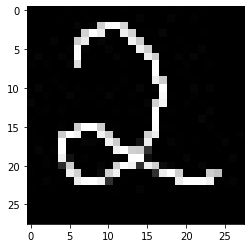

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.imshow(pixel_list[2], cmap = mpl.cm.binary)
plt.show()

In [54]:
reshaped_pixels = [pixel_matrix.reshape(784) for pixel_matrix in pixel_list ]
input_data = pd.DataFrame(reshaped_pixels)

In [55]:
X_input = input_data.values
y_input = np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9])


In [58]:
model.fit(X,y)
yhat_input = model.predict(X_input)
print(accuracy_score(y_input, yhat_input))

0.2


In [57]:
yhat_input

array([7, 7, 1, 7, 7, 7, 1, 7, 1, 7, 7, 1, 7, 3, 7, 7, 6, 7, 5, 3],
      dtype=int64)

In [60]:
file_test_path = get_file_path("test.csv", "original data")
df_test = pd.read_csv(file_test_path)
df_test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
imageid = [i for i in range(1,df_test.shape[0]+1)]
X_test_sub = df_test.values
yhat_sub = model.predict(X_test_sub)

dic_sub={
    "ImageId":imageid,
    "Label":yhat_sub
}

df_submission = pd.DataFrame(dic_sub)
submission_path = os.path.join(get_file_path("", "submissions"),"rand_forest_sub.csv")
df_submission.to_csv(submission_path, index = False)